In [19]:
import gurobipy as gp
from gurobipy import *
import numpy as np
from numpy import loadtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import random
random.seed(10)
import time
from heapq import nsmallest

from scipy.stats import cauchy
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [20]:
from ipynb.fs.full.Heuristics import *

In [21]:

# Convex hull location set

# 49 nodes data set
#Hull set Low
#80% [46, 41, 34, 29, 23, 21,  8,  7,  4,  2,  0]
#90% [46, 42, 41, 39, 37, 34, 31, 29, 23, 21, 16, 15, 13, 10,  8,  7, 6,  5,  4,  2,  1,  0]

#Hull set Med

#80% [45, 29, 21, 14, 13,  9,  7,  4,  2,  0]
#90% [47, 45, 35, 30, 29, 28, 25, 21, 20, 15, 14, 13, 10,  9,  7,  6, 4,  2,  0]

#Hull set HIGH

#80% [48, 32, 29, 26, 23, 21,  7,  6,  4,  2,  0]
#90% [48, 45, 37, 36, 32, 31, 29, 27, 26, 23, 21, 13, 12, 11,  7,  6,  4,  2,  0]


# 88 nodes data set
#80% [81, 77, 66, 58, 53, 45, 32, 29, 16, 12, 6, 4, 3]
#90% [81, 77, 66, 64, 60, 58, 53, 46, 45, 44, 42, 39, 32, 29, 16, 12, 11, 6, 5, 4, 3,67,7]

# 150 nodes data set
#80% [136, 121, 94, 56, 43, 37, 34, 7, 2, 1, 0]
#90% [139, 137, 136, 135, 121, 119, 112, 111, 108, 101, 94, 92, 87, 85, 82, 79, 74, 60, 56, 44, 43, 37, 34, 31, 27, 20, 18, 14, 8, 7, 3, 2, 1, 0]


In [22]:
df_csv = pd.read_csv('  ')  # Load dataset

def lat_lon_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = geopy.distance.distance(result[i], result[j]).km*0.621371
    return dist
length = df_csv.shape[0]
c_ij = lat_lon_distmatrix(df_csv)*(10**(-5))
c_ij[:,length] = c_ij[:,length]+0.1  #Emergency cost


V_1 = [i for i in range(0, length)] # Customer
V_2 = [i for i in range(0, length+1)] # Facility + Emergency
R = [i for i in range(0, 3)] #Backup leve
T = [i for i in range(1, 5)] #Time 4 period  (1,5)
TE = [i for i in range(0, 5)] # include period 0 (0,5)



# Initial period 0
#[0, 2, 4, 7, 21, 29]           for 49 node data set
# [3,4,6,16,29,32,45,58,66]     for 88 node data set
# [0,1,2,7,34,37,136]           for 150 node data set

set_init = set([0, 2, 4, 7, 21, 29])


###### Convex Hull ########

# define node from convex hull method (our experiment use 90% to define location set)
Hull_set = [139, 137, 136, 135, 121, 119, 112, 111, 108, 101, 94, 92, 87, 85, 82, 79, 74, 60, 56, 44, 43, 37, 34, 31, 27, 20, 18, 14, 8, 7, 3, 2, 1, 0]

Hull_set = list(set_init.union(Hull_set))

V_2 = Hull_set +[length] 

###########################


d_i = list(df_csv['demand']*10000)

f_j = list(df_csv['fixed cost']) + [0]

#A = [(i, j, r, t) for i in V_1 for j in V_2 for r in R for t in T]
A = [(i, j, r) for i in V_1 for r in R for j in V_2 ]

J = V_2[-1]
E = [(i, j) for i in V_1 for j in V_2 ]

#A_1 = [(i, j, r, t) for i in V_1 for j in V_2[:-1] for r in R[:-1] for t in T]
A_1 = [(i, j, r) for i in V_1 for r in R[:-1] for j in V_2[:-1] ]

o = 3000/1
c = 3000/1
jt = [(j, t) for j in V_2 for t in T]

## Multi period information #####################
q_jt = np.zeros((len(V_1)+1,4))
info = [1,2,4,8]
for i in range(0,4):
    q_jt[:,i] = list(df_csv['prob_fail'] *(info[i])) + [0] #Prob_fail + Emergency facility
    # (i+1)*0.25


d_it = np.zeros((len(d_i),4))
rho = 0 #0, 0.5, 1 
for i in range(0,4):
    d_it[:,i] = np.array(d_i)*((q_jt[:-1,i]*rho)+1) #Prob_fail + Emergency facility

    
for i in V_1:
    #if i not in idx_fix:      
    f_j[i] =  f_j[i]/10
##################################################


#info = [0.1, 0.5, 1.0, 2.5]   Result diff 2 %
#info = [0.1, 0.2, 0.8, 3.0]   Result diff 3.4 %


# SA

In [14]:
def setup_LRUFL(X,V_1,V_2, R):
    open_loc = [i for i in range(len(X)) if X[i]>0]
    open_loc.append(V_2[-1])
    Arc = [(i, j, r) for i in V_1 for j in open_loc for r in R ]
    E = [(i, j) for i in V_1 for j in open_loc ]
    Arc_1 = [(i, j, r) for i in V_1 for j in open_loc[:-1] for r in R[:-1]]
    
    return Arc, E, Arc_1, open_loc


def LRUFL_givenX(X, V_1, V_2, R, d_i, q_j, f_j, A, J, E, A_1):
    m = gp.Model("LRUFLX")
    m.Params.OutputFlag = 0
    
    x = X
    y = m.addVars(A, vtype=GRB.BINARY, name ="y")
    p = m.addVars(A, vtype=GRB.CONTINUOUS, name ="p")
    w = m.addVars(A, vtype=GRB.CONTINUOUS, name ="w")


    m.setObjective(quicksum(w[i, j, r]*c_ij[i, j]*d_i[i] for i,j,r in A) +  quicksum(f_j[j]*x[j] for j in V_2[:-1]),
                   GRB.MINIMIZE)

    # Constraint 1b
    m.addConstrs( quicksum(y[i, j, r] for j in V_2[:-1]) + quicksum(y[i, J, s] for s in range(r+1))  == 1 
                 for i in V_1 for r in R)

    # Constraint 1c
    m.addConstrs( quicksum(y[i, j, r] for r in R[:-1])  <= x[j]
                 for i in V_1 for j in V_2[:-1] )

    # Constraint 1d
    m.addConstrs( quicksum(y[i, J, r] for r in R)  == 1
                 for i in V_1 )

    # Constraint 1e
    m.addConstrs( p[i, j, 0]  == 1-q_j[j]
                 for i in V_1 for j in V_2 )

    # Constraint 1f (revise)
    m.addConstrs( p[i, j, r]  == (1-q_j[j])*quicksum(q_j[k]*w[i, k, r-1]/(1-q_j[k]) for k in V_2[:-1])
                 for i in V_1 for j in V_2 for r in R[1:] )

    # Constraint 2a
    m.addConstrs( w[i, j, r]  <= p[i, j, r]
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2b
    m.addConstrs( w[i, j, r]  <= y[i, j, r]
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2c
    m.addConstrs( w[i, j, r]  >= 0
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2d
    m.addConstrs( w[i, j, r]  >= p[i, j, r]+y[i, j, r]-1
                 for i in V_1 for j in V_2 for r in R)

    m.optimize()

    Var_cost = m.ObjVal - np.dot(f_j[:-1], x)
    
    Y_sol = {}
    W_sol = {}
    for i,j,r in A:
        if y[(i,j,r)].x >= 0.5:
            Y_sol[i,j,r] = 1
            W_sol[i,j,r] = w[(i,j,r)].x
    
    return m.ObjVal, Var_cost , Y_sol, W_sol


In [15]:
def neighborhood_search(num , X, w, c_ij, q_jt, t , Hull_set, T):
    if num == 0:
        x_can = cluster_move(X, w, c_ij, q_jt, t, Hull_set, T)
    elif num == 1:
        x_can = cross_move(X, w, q_jt, c_ij, t, T,Hull_set)
    elif num == 2 :
        x_can = balance_move(X, w, c_ij, q_jt, t, Hull_set, T)
    elif num == 3:
        x_can = add_move(X, q_jt , t, T,Hull_set)
        y, w = nearest_YSol(q_jt, c_ij, x_can, V_1, V_2, R, t)
        x_can = balance_move(x_can, w, c_ij, q_jt, t, Hull_set, T)
    else:
        x_can = remove_move(X, q_jt , t, T)
        y, w = nearest_YSol(q_jt, c_ij, x_can, V_1, V_2, R, t)
        x_can = balance_move(x_can, w, c_ij, q_jt, t, Hull_set, T)
    return x_can
    

# Result

# SMC SA

In [16]:
#Initialize state
#Update weighted
#Resampling
#move state
def state_init(N_k, search, A, V_1, V_2, R, X_init, w, c_ij, q_jt, d_it, 
               f_j ,t , Hull_set, Tem , open_cost): #x_set = [(state,value) , ....]
    T = Tem*10 #########
    x_set = []
    cost_list= []
    weight_list = np.zeros(N_k)
    Y_list = []
    W_list = []
    
    ############################## Keep initial at 0 #############################################
    
    Arc, E, Arc_1, open_loc = setup_LRUFL(X_init,V_1,V_2, R)
    _, _, Y_sol, W_sol = LRUFL_givenX(X_init, V_1, open_loc, R, d_it[:,t], q_jt[:,t], f_j, Arc, V_2[-1], E, Arc_1)

    ########################### Future information ##################
    Val_cost = 0
    Fix_cost = cal_Fixcost(X_init, f_j, V_2)*min(4-t,2)
    for tt in range(t,min(t+2,4)): # consider next period
        Val_cost = Val_cost + cal_Valcost(X_init, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
    ################################################################

    candidate_cost = Fix_cost + Val_cost 

    x_set.append(X_init)
    cost_list.append(candidate_cost)
    weight_list[0] = np.exp(-candidate_cost/T)
    Y_list.append(Y_sol)
    W_list.append(W_sol)
    #################################################################
    
    
    for i in range(1,N_k): ## Start from 1 for heeping original at 0
        num = random.randint(0,search)
        X_can = neighborhood_search(num , X_init, w, c_ij, q_jt, t , Hull_set, T)
        Y_sol, W_sol = nearest_YSol(q_jt, c_ij, X_can, V_1, V_2, R, t) 
        # get the candidate cost
        
        ########################### Futre information ##################
        Val_cost = 0
        Fix_cost = cal_Fixcost(X_can, f_j, V_2)*min(4-t,2)

        for tt in range(t,min(t+2,4)): # consider next period
            Val_cost = Val_cost + cal_Valcost(X_can, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
        ################################################################

        candidate_cost = Fix_cost + Val_cost + cal_Opencost(X_can, X_init, open_cost)
        
        
        x_set.append(X_can)
        cost_list.append(candidate_cost)
        weight_list[i] = np.exp(-candidate_cost/T)
        Y_list.append(Y_sol)
        W_list.append(W_sol)
        
    sum_w = np.sum(weight_list)
    weight_list = weight_list/sum_w

    return x_set, cost_list, weight_list, Y_list, W_list

def update_weighted(N_k, cost_list, Tem, alpha): #x_set = [(state,value) , ....]
    T = Tem*10 #########
    weight_list = np.zeros(N_k)
    
    for i in range(N_k):
        weight_list[i] = np.exp(-cost_list[i]*((1/T)-(alpha/T)))
        
    sum_w = np.sum(weight_list)
    weight_list = weight_list/sum_w
  
    return weight_list

def sampling(N_k, x_set, cost_list, weight_list, Y_list, W_list):
    #append resampling
    new_x = []
    nex_cost = []
    new_y = []
    new_w =[]
    
    #Note particle sampling with differnt node region
    #########################################################################
    #Original
    new_x.append(x_set[0])
    nex_cost.append(cost_list[0])
    new_y.append(Y_list[0])
    new_w.append(W_list[0])
    
    #Add
    new_x.append(x_set[1])
    nex_cost.append(cost_list[1])
    new_y.append(Y_list[1])
    new_w.append(W_list[1])
    
    #remove
    new_x.append(x_set[2])
    nex_cost.append(cost_list[2])
    new_y.append(Y_list[2])
    new_w.append(W_list[2])
    #########################################################################
    
    #sampling
    for i in range(3,N_k): #########################################################################
        idx_choice = np.random.choice(list(np.arange(N_k, dtype=int)), p= list(weight_list))
        
        new_x.append(x_set[idx_choice])
        nex_cost.append(cost_list[idx_choice])
        new_y.append(Y_list[idx_choice])
        new_w.append(W_list[idx_choice])
    
    return new_x, nex_cost, weight_list, new_y, new_w

def move_SA(N_k, search, A, V_1, V_2, R, x_set, cost_list, Y_list, W_list, X_init, 
            c_ij, q_jt, d_it, f_j ,t , Hull_set, Tem , open_cost):
    new_x = []
    nex_cost = []
    new_y = []
    new_w =[]
    
    for i in range(N_k):
        num = random.randint(0,search)
        X = x_set[i]
        y, w = Y_list[i], W_list[i]
        X_can = neighborhood_search(num , X, w, c_ij, q_jt, t , Hull_set, Tem)
        
        
        if Tem > 300: #useing precise assignment ###########################################
            Y_sol, W_sol = nearest_YSol(q_jt, c_ij, X_can, V_1, V_2, R, t) 
            # get the candidate cost
            
            ########################### Futre information ##################
            Val_cost = 0
            Fix_cost = cal_Fixcost(X_can, f_j, V_2)*min(4-t,2)
            
            for tt in range(t,min(t+2,4)): # consider next period
                Val_cost = Val_cost + cal_Valcost(X_can, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
            ################################################################

            candidate_cost = Fix_cost + Val_cost + cal_Opencost(X_can, X_init, open_cost)
        else:
            
            Arc, E, Arc_1, open_loc = setup_LRUFL(X_can,V_1,V_2, R)
            _, _, Y_sol, W_sol = LRUFL_givenX(X_can, V_1, open_loc, R, d_it[:,t], q_jt[:,t], f_j, Arc, V_2[-1], E, Arc_1)
            
            ########################### Futre information ##################
            Val_cost = 0
            Fix_cost = cal_Fixcost(X_can, f_j, V_2)*min(4-t,2)
            for tt in range(t,min(t+2,4)): # consider next period
                Val_cost = Val_cost + cal_Valcost(X_can, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
            ################################################################
            
            candidate_cost = Fix_cost + Val_cost + cal_Opencost(X_can, X_init, open_cost)
        #Accept or reject
        r = random.random()
        if candidate_cost < cost_list[i]:
            new_x.append(X_can)
            nex_cost.append(candidate_cost)
            new_y.append(Y_sol)
            new_w.append(W_sol)
        ##################################################################
        elif r < (Tem**2)/((Tem**2)+(candidate_cost - cost_list[i])**2): # Cauchy
        #elif r < np.exp(- (candidate_cost - cost_list[i])/Tem ): # Boltzmann
        
            new_x.append(X_can)
            nex_cost.append(candidate_cost)
            new_y.append(Y_sol)
            new_w.append(W_sol)
        ##################################################################
        else:
            new_x.append(x_set[i])
            nex_cost.append(cost_list[i])
            new_y.append(Y_list[i])
            new_w.append(W_list[i])

    return new_x, nex_cost, new_y, new_w

def Add_node(N_k, search, A, V_1, V_2, R, x_set, cost_list, Y_list, W_list, X_init, 
            c_ij, q_jt, d_it, f_j ,t , Hull_set, Tem , open_cost):
    new_x = []
    nex_cost = []
    new_y = []
    new_w =[]
    
    for i in [1] + list(range(3,10)): # for i in range(N_k):
        num = 3 # Add move
        X = x_set[i]
        y, w = Y_list[i], W_list[i]
        
        X_can = neighborhood_search(num , X, w, c_ij, q_jt, t , Hull_set, Tem)
        Y_sol, W_sol = nearest_YSol(q_jt, c_ij, X_can, V_1, V_2, R, t) 
        # get the candidate cost
        
        ########################### Futre information ##################
        Val_cost = 0
        Fix_cost = cal_Fixcost(X_can, f_j, V_2)*min(4-t,2)
        for tt in range(t,min(t+2,4)): # consider next period
            Val_cost = Val_cost + cal_Valcost(X_can, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
        ################################################################
        candidate_cost = Fix_cost + Val_cost + cal_Opencost(X_can, X_init, open_cost)
        
        
        '''new_x.append(X_can)
        nex_cost.append(candidate_cost)
        new_y.append(Y_sol)
        new_w.append(W_sol)'''
        x_set[i] = X_can
        Y_list[i] = Y_sol
        W_list[i] = W_sol
        cost_list[i] = candidate_cost
    
    for i in [2] + list(range(11,20)): # for i in range(N_k):
        num = 4 # Remove
        X = x_set[i]
        y, w = Y_list[i], W_list[i]
        
        X_can = neighborhood_search(num , X, w, c_ij, q_jt, t , Hull_set, Tem)
        Y_sol, W_sol = nearest_YSol(q_jt, c_ij, X_can, V_1, V_2, R, t) 
        # get the candidate cost
        
        ########################### Futre information ##################
        Val_cost = 0
        Fix_cost = cal_Fixcost(X_can, f_j, V_2)*min(4-t,2)
        for tt in range(t,min(t+2,4)): # consider next period
            Val_cost = Val_cost + cal_Valcost(X_can, q_jt, Y_sol, c_ij, list(d_it[:,tt]),V_1, V_2, R, tt)
        ################################################################
        candidate_cost = Fix_cost + Val_cost + cal_Opencost(X_can, X_init, open_cost)
        
        
        '''new_x.append(X_can)
        nex_cost.append(candidate_cost)
        new_y.append(Y_sol)
        new_w.append(W_sol)'''
        x_set[i] = X_can
        Y_list[i] = Y_sol
        W_list[i] = W_sol
        cost_list[i] = candidate_cost
    return x_set, cost_list, Y_list, W_list#new_x, nex_cost, new_y, new_w

In [524]:
# RUN #
OUTPUT = {}
#OUTPUT[-1] = [0, 2, 4, 7, 21, 29]# from set risk 0  [3,4,6,16,29,32,45,58,66] , [0,1,2,7,34,37,136]
OUTPUT[-1] = list(set_init)
COST = 0
######## parameter setup #####
alpha = 0.98
Tem_s = 800
Tem_f = 300
search = 2 #cluster , cross , balance, add, remove
N_k = 40
time_start = time.time()

counter = 0 #count for repeating best solution
f_count = 0

stop_count = 0 #count for not improving search
stop_limit = 10

prev_cost = 0
stop_it = 1 #stop iter
#############################

########## for PLOT ###################
plot_y = {}
for t in range(4):
    for i in range(N_k):
        plot_y["{}_{}".format(t,i)] = []
########################################

for t in range(4):

    Tem = Tem_s
    #############
    open_cost = 3000
    #############
    ### STATE ###
    idx_x = OUTPUT[t-1]
    X = np.zeros(len(V_1))
    for i in idx_x:
        X[i] = 1
    X_init = X.copy()
    y, w = nearest_YSol(q_jt, c_ij, X_init, V_1, V_2, R, t)
    
    
    x_set, cost_list, weight_list, Y_list, W_list = state_init(N_k, search, A, V_1, V_2, R, X_init, 
                                                               w, c_ij, q_jt, d_it, f_j ,t , Hull_set, 
                                                               Tem , open_cost)
    
    best_cost = cost_list[0]
    best_x = x_set[0]
    best_y = Y_list[0]
    best_w = W_list[0]
    
    x_set, cost_list, Y_list, W_list = Add_node(N_k, search, A, V_1, V_2, R, x_set, cost_list, 
                                                                Y_list, W_list, X_init, c_ij, q_jt, 
                                                                d_it, f_j ,t , Hull_set, Tem , open_cost)
    


    ###############################
    while Tem >= Tem_f:
        

        x_set, cost_list, weight_list, Y_list, W_list = sampling(N_k, x_set, cost_list, weight_list, Y_list, W_list)
        
        if stop_count == stop_limit-3:
            x_set, cost_list, Y_list, W_list = move_SA(N_k, search, A, V_1, V_2, R, x_set, cost_list, 
                                                                Y_list, W_list, X_init, c_ij, q_jt, 
                                                                d_it, f_j ,t , Hull_set, Tem_f , open_cost)
        else:
            x_set, cost_list, Y_list, W_list = move_SA(N_k, search, A, V_1, V_2, R, x_set, cost_list, 
                                                                Y_list, W_list, X_init, c_ij, q_jt, 
                                                                d_it, f_j ,t , Hull_set, Tem , open_cost)
            
        
        Tem = Tem*alpha
        print("Period {}, Temperature {}".format(t,Tem))
        #memo best solution during the process
        idx_best = np.argmin(cost_list)
        if cost_list[idx_best] < best_cost:
            best_cost = cost_list[idx_best]
            best_x = x_set[idx_best]
            best_y = Y_list[idx_best]
            best_w = W_list[idx_best]
            counter = 0
        elif counter == f_count:
            #idx_worse = np.argmax(cost_list)
            idx_worse = 10
            cost_list[idx_worse] = best_cost
            x_set[idx_worse] = best_x
            Y_list[idx_worse] = best_y
            W_list[idx_worse] = best_w
            counter = 0
        else:
            counter = counter+1
            
        for i in range(N_k):
            plot_y["{}_{}".format(t,i)].append(cost_list[i])

        weight_list = update_weighted(N_k, cost_list, Tem, alpha)

        #how to identify not improve stop searching
        if (((np.sum(cost_list)/N_k) - best_cost)/best_cost) <= 0.01:
            stop_count = stop_count+1
            if stop_count == stop_limit:
                stop_count = 0
                break
        elif Tem < Tem_f*1.1:
            stop_count = 0
            #Tem_f = Tem_f*0.95
            if Tem_f <290:
                break
        else:
            stop_count = 0

        prev_cost = cost_list


    Arc, E, Arc_1, open_loc = setup_LRUFL(best_x,V_1,V_2, R)
    Total_cost, _, y, w = LRUFL_givenX(best_x, V_1, open_loc, R, d_it[:,t], q_jt[:,t], f_j, Arc, J, E, Arc_1)
    
    COST = (COST + Total_cost
            + cal_Opencost(best_x, X_init, open_cost)) ##########open_cost*(4-t)
    '''
    COST = (COST + cal_Fixcost(best_x, f_j, V_2) + 
            cal_Valcost(best_x,q_jt, best_y, c_ij, list(d_it[:,t]), V_1, V_2, R, t) 
            + cal_Opencost(best_x, X_init, open_cost*(4-t)))'''
    OUTPUT[t] = [idx for idx, element in enumerate(best_x) if condition(element)]
    
    Tem_f = 300
    stop_count = 0 #prevent break next timeperiod


print("time : {}".format(time.time() - time_start))

Period 0, Temperature 784.0
Period 0, Temperature 768.3199999999999
Period 0, Temperature 752.9535999999999
Period 0, Temperature 737.8945279999999
Period 0, Temperature 723.13663744
Period 0, Temperature 708.6739046911999
Period 0, Temperature 694.500426597376
Period 0, Temperature 680.6104180654285
Period 0, Temperature 666.9982097041199
Period 0, Temperature 653.6582455100374
Period 0, Temperature 640.5850805998367
Period 0, Temperature 627.7733789878399
Period 0, Temperature 615.2179114080831
Period 0, Temperature 602.9135531799215
Period 0, Temperature 590.855282116323
Period 0, Temperature 579.0381764739965
Period 0, Temperature 567.4574129445166
Period 0, Temperature 556.1082646856263
Period 0, Temperature 544.9860993919137
Period 0, Temperature 534.0863774040755
Period 0, Temperature 523.404649855994
Period 0, Temperature 512.936556858874
Period 0, Temperature 502.67782572169654
Period 0, Temperature 492.6242692072626
Period 0, Temperature 482.77178382311735
Period 0, Temperatu

In [531]:
COST


726559.2266504103

In [528]:
OUTPUT

{-1: [0, 1, 2, 34, 37, 7, 136],
 0: [0, 1, 7, 8, 14, 37, 94],
 1: [0, 8, 14, 37, 56, 94, 108],
 2: [0, 8, 14, 37, 56, 94, 108],
 3: [0, 8, 14, 37, 56, 94, 108]}

# Plot

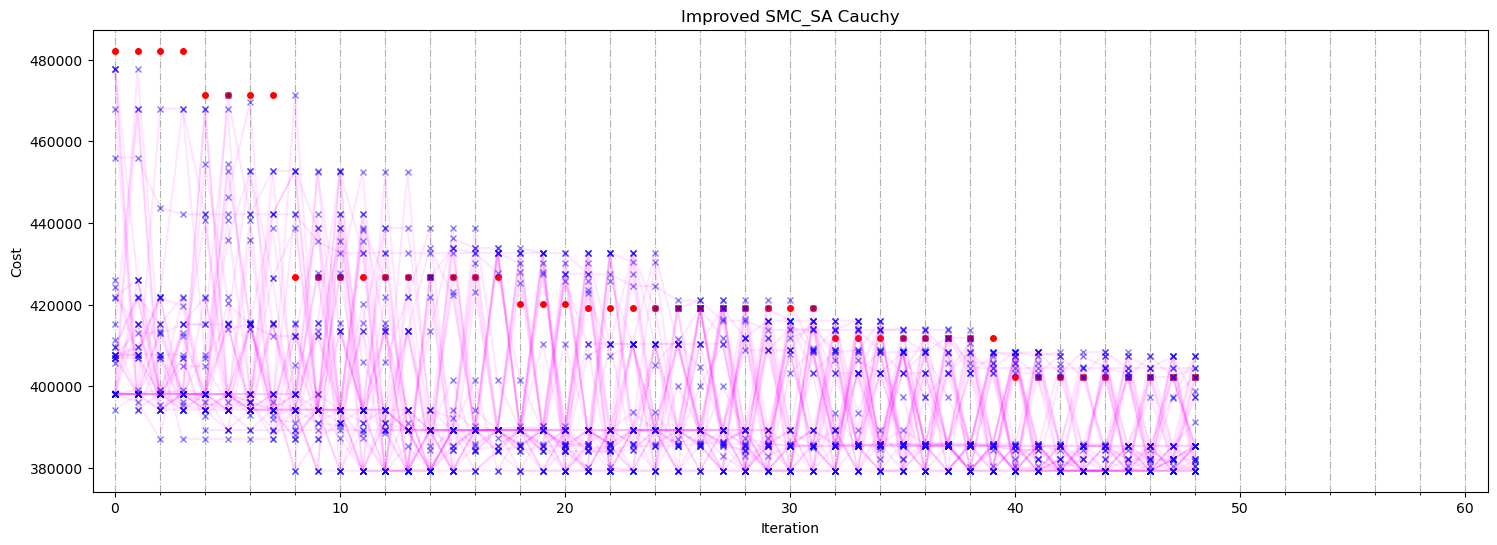

In [411]:

fig,ax = plt.subplots(figsize=(18, 6))
#fig = plt.figure(figsize=(w, h), dpi=dpi)
t = 0

for i in range(N_k):
    if i == 2:
        ax.plot(range(len(plot_y["{}_{}".format(t,i)])), plot_y["{}_{}".format(t,i)],'o', alpha = 1, c = 'r', ms = 4)
    else:
        ax.plot(range(len(plot_y["{}_{}".format(t,i)])), plot_y["{}_{}".format(t,i)],'x', alpha = 0.5, c = 'b', ms = 4)
        ax.plot(range(len(plot_y["{}_{}".format(t,i)])), plot_y["{}_{}".format(t,i)],'-', alpha = 0.1, c = 'fuchsia', ms = 4)
    
ax.set(xlabel = "Iteration", ylabel = "Cost" , title= "Improved SMC_SA Cauchy")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(visible=None, which='both', axis='x', linestyle = '-.')
ax.set_xlim([-1,61])
#ax.set_ylim([375000, 470000])
#plt.ylim([95000, 135000])
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
#plt.yticks(np.arange(0, 1.1, 0.1))
# Display

plt.show()